In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [2]:
import numpy as np
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_scatter import scatter_add
from torch_geometric.datasets import Planetoid, CitationFull
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import Coauthor, Amazon
import torch_geometric.transforms as T
from torch.nn import Parameter
import torch.nn.functional as F
import torch.nn as nn
import torch
import os

from eval import label_classification
from model import Model, GCNConv, Encoder
from utils import random_coauthor_amazon_splits, random_planetoid_splits, normalize_adj_row, normalize_adj

from sklearn.decomposition import PCA

In [4]:

import numpy as np
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_scatter import scatter_add
from torch_geometric.datasets import Planetoid, CitationFull
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import Coauthor, Amazon
import torch_geometric.transforms as T
from torch.nn import Parameter
import torch.nn.functional as F
import torch.nn as nn
import torch
import os

from eval import label_classification
from model import Model, GCNConv, Encoder
from utils import random_coauthor_amazon_splits, random_planetoid_splits, normalize_adj_row, normalize_adj



seed = 21415
learning_rate = 0.001
num_hidden = 1024
num_out = 512
activation = F.relu
base_model = GCNConv
num_epochs = 20
weight_decay = 0.0001
gam1 = 0.5
gam2 = 0.5
eps = 0.05
num_layers = 1
num_node_batch = 768

torch.manual_seed(seed)
np.random.seed(seed)
torch.set_num_threads(3)



path = os.path.join("/data/han/pgnn/data")


dataset = Planetoid(path, 'Cora', transform=T.NormalizeFeatures())
data = dataset[0]
data.num_classes = dataset.num_classes

print("Number of Nodes:", data.x.shape[0])
print("Number of Nodes Features:", data.x.shape[1])
print("Number of Edges:", data.edge_index.shape[1])


node_num = data.x.shape[0]
num_features = data.x.shape[1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

A = to_dense_adj(data.edge_index)[0].cpu()
A = normalize_adj_row(A)
A = torch.from_numpy(A.todense())





class MaximalCodingRateReduction(torch.nn.Module):
    def __init__(self, gam1=1.0, gam2=1.0, eps=0.01):
        super(MaximalCodingRateReduction, self).__init__()
        self.gam1 = gam1
        self.gam2 = gam2
        self.eps = eps

    def projection(self, z: torch.Tensor) -> torch.Tensor:
        z = F.normalize(z, dim=0)
        return z

    def compute_discrimn_loss_empirical(self, W):
        """Empirical Discriminative Loss."""
        p, m = W.shape
        I = torch.eye(p).cuda()
        scalar = p / (m * self.eps)
        logdet = torch.logdet(I + self.gam1 * scalar * W.matmul(W.T))
        return logdet / 2.

    def compute_compress_loss_empirical_all(self, W, Pi):
        """Empirical Compressive Loss."""
        p, m = W.shape
        k, _ = Pi.shape
        sum_trPi = torch.sum(Pi)

        I = torch.eye(p).cuda()
        compress_loss = 0.
        for j in range(k):
            trPi = torch.sum(Pi[j]) + 1e-8
            scalar = p / (trPi * self.eps)
            a = W.T * Pi[j].view(-1, 1)
            a = a.T
            log_det = torch.logdet(I + scalar * a.matmul(W.T))
            compress_loss += log_det * trPi / m
        num = data.x.shape[0]
        compress_loss = compress_loss / 2 * (num / sum_trPi)
        return compress_loss

    def forward(self, X, A):

        i = np.random.randint(A.shape[0], size=num_node_batch)
        A = A[i,::]

        A = A.cpu().numpy()
        W = X.T
        Pi = A
        Pi = torch.tensor(Pi, dtype=torch.float32).cuda()

        discrimn_loss_empi = self.compute_discrimn_loss_empirical(W)
        compress_loss_empi = self.compute_compress_loss_empirical_all(W, Pi)
        total_loss_empi = - self.gam2 * discrimn_loss_empi + compress_loss_empi
        return total_loss_empi


def train(model: Model, x, edge_index, A, MaximalCodingRateReduction: MaximalCodingRateReduction):
    model.train()
    optimizer.zero_grad()
    z = model(x, edge_index)
    loss = MaximalCodingRateReduction(z, A)
    loss.backward()
    optimizer.step()
    return loss.item()


def test(model: Model, x, edge_index, y, train_mask=None, test_mask=None):
    model.eval()
    z = model(x, edge_index)
    x = z.detach().cpu().numpy()
    res = label_classification(z, y, train_mask=train_mask, test_mask=test_mask)
    return res



encoder = Encoder(in_channels=num_features,out_channels=num_out, hidden_channels=num_hidden, activation=activation,base_model=base_model, k=num_layers).to(device)
model = Model(encoder=encoder).to(device)
coding_rate_loss = MaximalCodingRateReduction(gam1=gam1, gam2=gam2, eps=eps).to(device)
optimizer = torch.optim.Adam( list(model.parameters()) + list(coding_rate_loss.parameters()), lr=learning_rate, weight_decay=weight_decay)


for epoch in range(1, num_epochs + 1):
    loss = train(model, data.x, data.edge_index, A, coding_rate_loss)
    val_res = test(model, data.x, data.edge_index, data.y, train_mask=data.train_mask.cpu().numpy(), test_mask=data.val_mask.cpu().numpy())
    test_res = test(model, data.x, data.edge_index, data.y, train_mask=data.train_mask.cpu().numpy(), test_mask=data.test_mask.cpu().numpy())
    print("Epoch: {:03d}, val_acc: {:.4f}, test_acc:{:.4f}".format(epoch, val_res["acc"], test_res["acc"] ))




Number of Nodes: 2708
Number of Nodes Features: 1433
Number of Edges: 10556
Epoch: 001, val_acc: 0.7720, test_acc:0.7770
Epoch: 002, val_acc: 0.7880, test_acc:0.8010
Epoch: 003, val_acc: 0.8080, test_acc:0.8180
Epoch: 004, val_acc: 0.8060, test_acc:0.8210
Epoch: 005, val_acc: 0.7980, test_acc:0.8220
Epoch: 006, val_acc: 0.8040, test_acc:0.8300
Epoch: 007, val_acc: 0.8080, test_acc:0.8280
Epoch: 008, val_acc: 0.8140, test_acc:0.8270
Epoch: 009, val_acc: 0.8160, test_acc:0.8350
Epoch: 010, val_acc: 0.8200, test_acc:0.8320
Epoch: 011, val_acc: 0.8180, test_acc:0.8330
Epoch: 012, val_acc: 0.8200, test_acc:0.8340
Epoch: 013, val_acc: 0.8180, test_acc:0.8340
Epoch: 014, val_acc: 0.8200, test_acc:0.8320
Epoch: 015, val_acc: 0.8180, test_acc:0.8320
Epoch: 016, val_acc: 0.8140, test_acc:0.8380
Epoch: 017, val_acc: 0.8220, test_acc:0.8410
Epoch: 018, val_acc: 0.8180, test_acc:0.8420
Epoch: 019, val_acc: 0.8180, test_acc:0.8460
Epoch: 020, val_acc: 0.8200, test_acc:0.8440


In [5]:
import sklearn as skl
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.datasets import Planetoid, TUDataset, CoraFull, Coauthor, Amazon
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv  # noqa
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.transforms import Bbox
from torch_geometric.utils import to_networkx
import networkx as nx


dataset = 'Cora'
path = os.path.join("/data/han/data/pgnn/data", dataset)
print("path:", path)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())

data = dataset[0]

G = to_networkx(data)
G = G.to_undirected()

y = data.y
X_orig = data.x
largest_cc = max(nx.connected_components(G), key=len)
largest_cc = G.subgraph(largest_cc).copy()

path: /data/han/data/pgnn/data/Cora


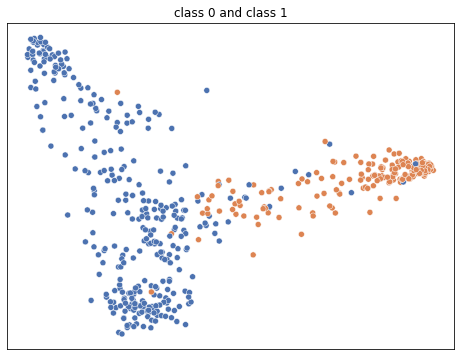

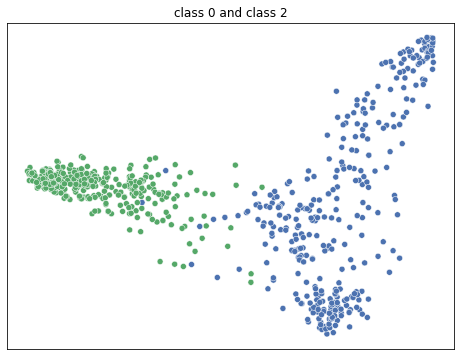

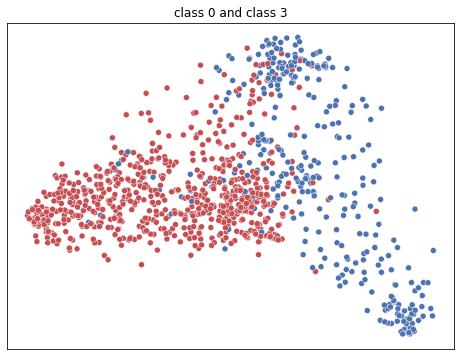

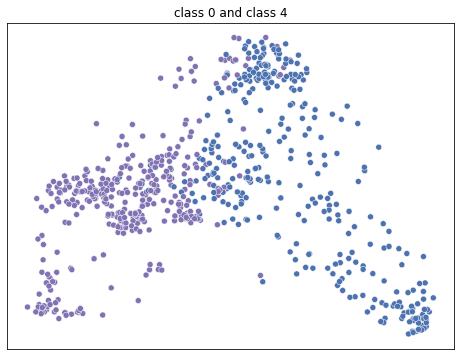

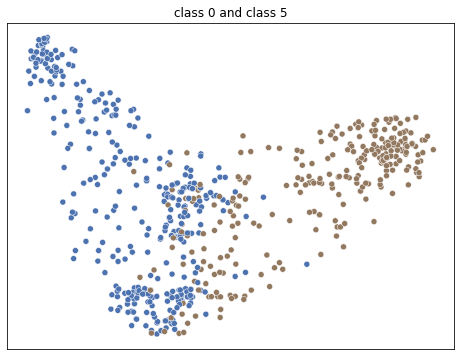

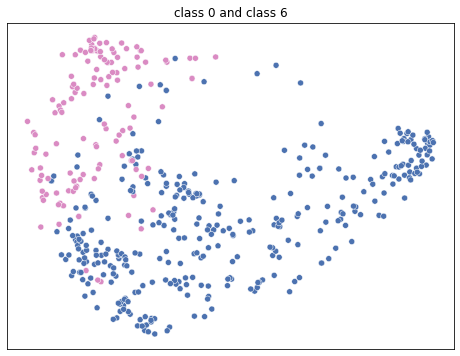

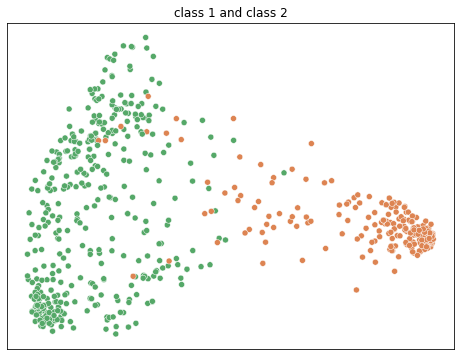

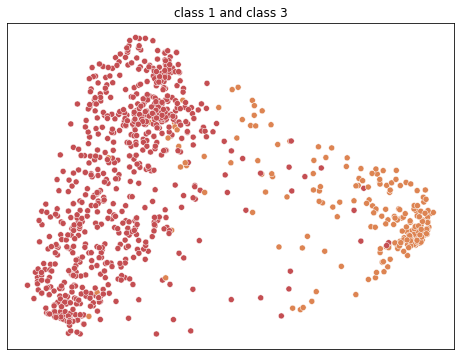

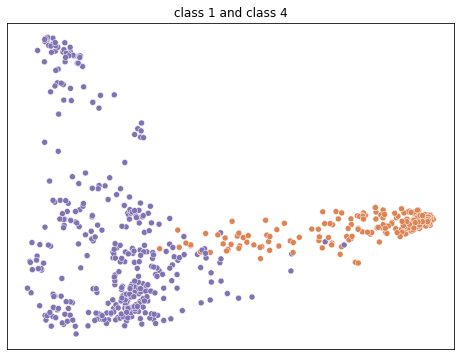

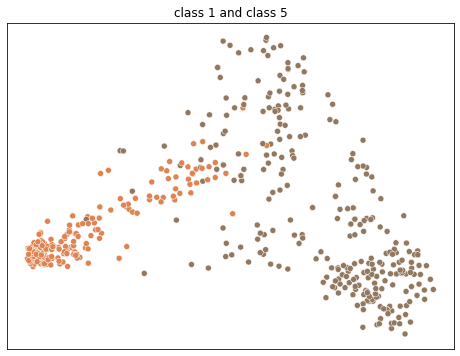

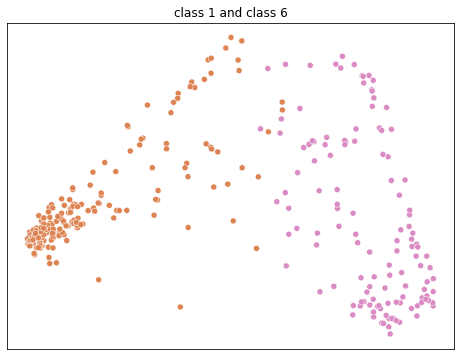

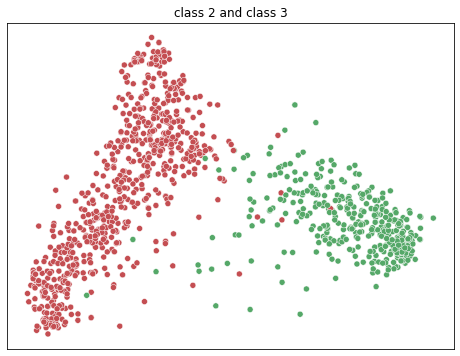

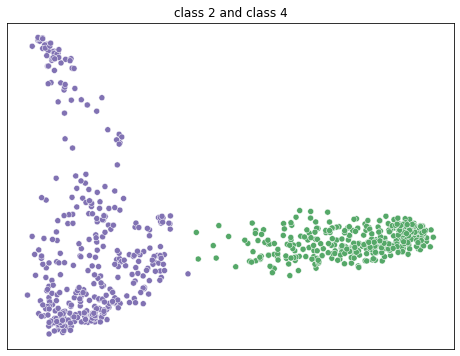

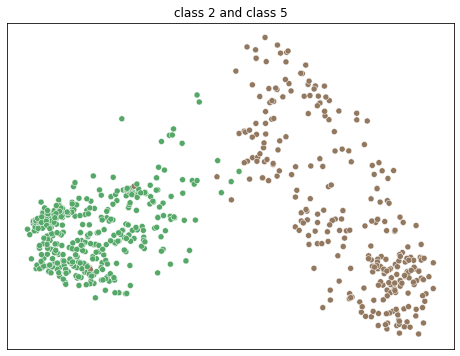

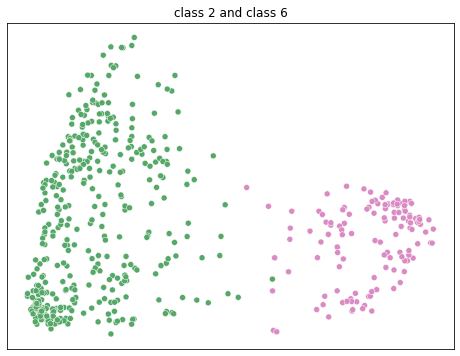

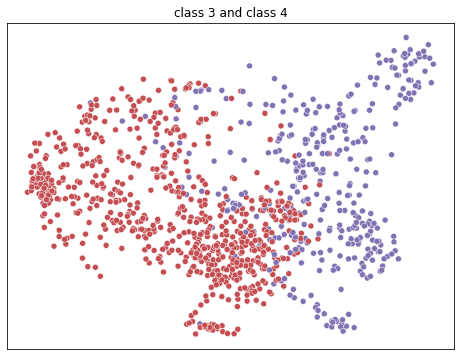

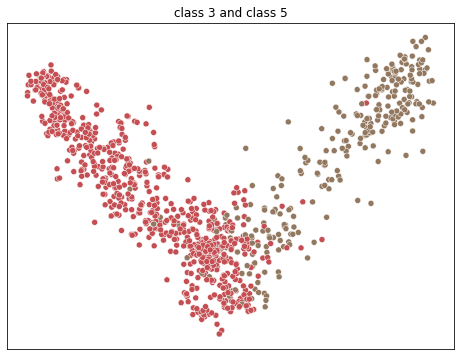

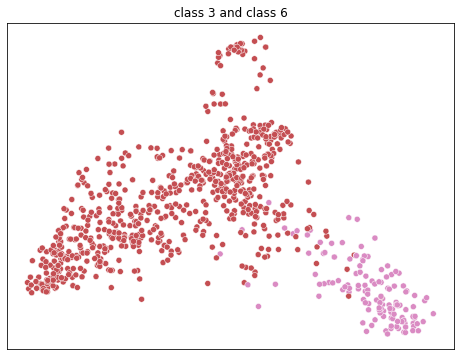

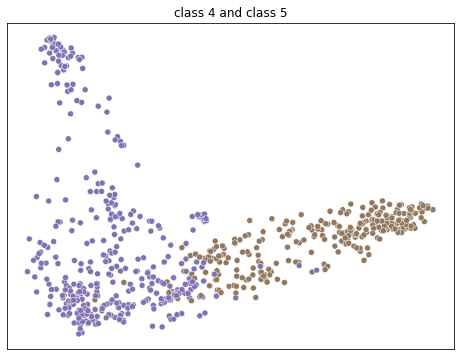

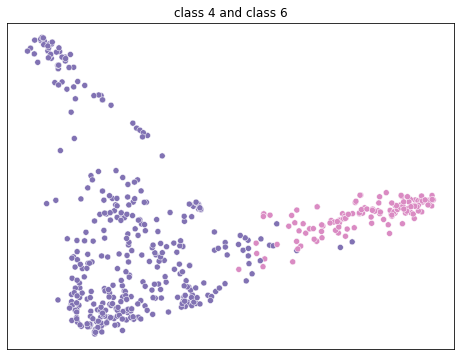

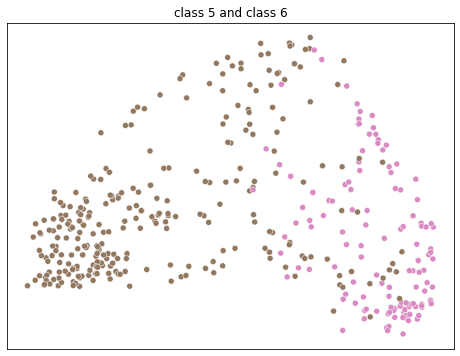

In [20]:
import pandas as pd

model.eval()
X_embd = model(data.x.to("cuda"), data.edge_index.to("cuda")).detach().cpu().numpy()

y = data.y

node_index = list(largest_cc.nodes)
X_embd = X_embd[node_index]
y = data.y.numpy()[node_index]


color_dict = dict({0:"#4C72B0", 
                    1: "#DD8452", 
                    2: "#55A868", 
                    3: "#C44E52",
                    4: "#8172B3",
                    5:"#937860",
                    6:"#DA8BC3",
                    7: "#8C8C8C",
                    8: "#CCB974",
                    9:"#64B5CD"})


for i in range(0, 7):
    for j in range(0, 7):
        if i < j:
            X_embd_tmp = X_embd[(y==i)|(y==j)]
            y_tmp = y[(y == i) | (y == j)]
    

            pca = PCA(n_components=2, svd_solver='full')
            X_embedded_2 = pca.fit_transform(X_embd_tmp)
    
            df2 = pd.DataFrame()
            df2['x'] = X_embedded_2[:, 0]
            df2['y'] = X_embedded_2[:, 1]
            df2['cluster'] = y_tmp
    
            fig, ax = plt.subplots(figsize=(8, 6))
            g = sns.scatterplot(ax=ax, data=df2, x="x", y="y", hue="cluster", palette=color_dict, legend =False)
            g.set(xlabel=None)
            g.set(ylabel=None)
            plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
            plt.title( f"class {i} and class {j}" )
            plt.show()
            


